# Basic example

We'll search for two months of Sentinel-2 data overlapping our area of interest—in this case, the Santa Fe ski area in New Mexico, USA ([Google maps](https://www.google.com/maps/place/35%C2%B047'24.0%22N+105%C2%B046'48.0%22W/@35.792066,-105.7907579,6065m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d35.79!4d-105.78)).

We use `stackstac` to create an xarray of all the data. From there, it's easy to filter out cloudy scenes from the array based on their metadata, then create a median composite for each month.

In [1]:
import stackstac

In [2]:
lon, lat = -105.78, 35.79

We use [pystac-client](https://pystac-client.readthedocs.io/) to find the relevant STAC (Spatio-Temporal Asset Catalog) items. These basically provide metadata about the relevant scenes, and links to their data.

We'll use element84's search endpoint to look for items from the `sentinel-s2-l2a-cogs` collection on AWS.

In [3]:
import pystac_client
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

In [4]:
%%time
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2020-04-01/2020-05-01"
).get_all_items()
len(items)

CPU times: user 7.6 ms, sys: 0 ns, total: 7.6 ms
Wall time: 351 ms


13

Use `stackstac` to turn those STAC items into a lazy xarray. Using all the defaults, our data will be in its native coordinate reference system, at the finest resolution of all the assets.

In [5]:
%time stack = stackstac.stack(items)

CPU times: user 68.3 ms, sys: 184 µs, total: 68.4 ms
Wall time: 67.5 ms


In [6]:
stack

<xarray.DataArray 'stackstac-f6a546155c0d41dd6f4dc51e2659d85b' (time: 13,
                                                                band: 17,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(13, 17, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                        (time) datetime64[ns] 2020-04-01T18:04:04 ......
    id                          (time) <U24 'S2B_13SDV_20200401_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'B11' ... 'visual' 'SCL'
  * x                           (x) float64 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y                           (y) float64 4e+06 4e+06 ... 3.89e+06 3.89e+06
    sentinel:utm_zone           int64 13
    ...                          ...
    sentinel:grid_square        <U2 'DV'
    eo:cloud_cover              (time) float64 29.24 1.16 27.26 ... 87.33 5.41
    sentinel:data_coverage      (time) float64 33.85 100.0 33.9 ... 100.0 34.29
    data_coverage               (time) object 33.85 100 33.9 ... 32.84 100 34.29
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

Well, that's really all there is to it. Now you have an xarray DataArray, and you can do whatever you like to it!

Here, we'll filter out scenes with >20% cloud coverage (according to the `eo:cloud_cover` field set by the data provider).
Then, pick the bands corresponding to red, green, and blue, and use xarray's `resample` to create 1-month median composites.

In [7]:
lowcloud = stack[stack["eo:cloud_cover"] < 20]
rgb = lowcloud.sel(band=["B04", "B03", "B02"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

In [8]:
monthly

<xarray.DataArray 'stackstac-f6a546155c0d41dd6f4dc51e2659d85b' (time: 2,
                                                                band: 3,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<stack, shape=(2, 3, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * band                        (band) <U8 'B04' 'B03' 'B02'
  * x                           (x) float64 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y                           (y) float64 4e+06 4e+06 ... 3.89e+06 3.89e+06
    sentinel:utm_zone           int64 13
    sentinel:sequence           <U1 '0'
    instruments                 <U3 'msi'
    ...                          ...
    view:off_nadir              int64 0
    constellation               <U10 'sentinel-2'
    sentinel:grid_square        <U2 'DV'
    title                       (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    epsg                        int64 32613
  * time                        (time) datetime64[ns] 2020-04-01 2020-05-01
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

So we don't pull all ~200 GB of data down to our local machine, let's slice out a little region around our area of interest.

We convert our lat-lon point to the data's UTM coordinate reference system, then use that to slice the `x` and `y` dimensions, which are indexed by their UTM coordinates.

In [9]:
import pyproj
x_utm, y_utm = pyproj.Proj(monthly.crs)(lon, lat)
buffer = 2000  # meters

In [10]:
aoi = monthly.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-f6a546155c0d41dd6f4dc51e2659d85b' (time: 2,
                                                                band: 3,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(2, 3, 400, 400), dtype=float64, chunksize=(1, 1, 387, 316), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * band                        (band) <U8 'B04' 'B03' 'B02'
  * x                           (x) float64 4.275e+05 4.275e+05 ... 4.315e+05
  * y                           (y) float64 3.963e+06 3.963e+06 ... 3.959e+06
    sentinel:utm_zone           int64 13
    sentinel:sequence           <U1 '0'
    instruments                 <U3 'msi'
    ...                          ...
    view:off_nadir              int64 0
    constellation               <U10 'sentinel-2'
    sentinel:grid_square        <U2 'DV'
    title                       (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    epsg                        int64 32613
  * time                        (time) datetime64[ns] 2020-04-01 2020-05-01
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

In [11]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = aoi.compute()

[###########                             ] | 27% Completed | 5.64 sms

/home/lauren/miniconda3/envs/pystac-env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


[########################################] | 100% Completed | 17.73 s


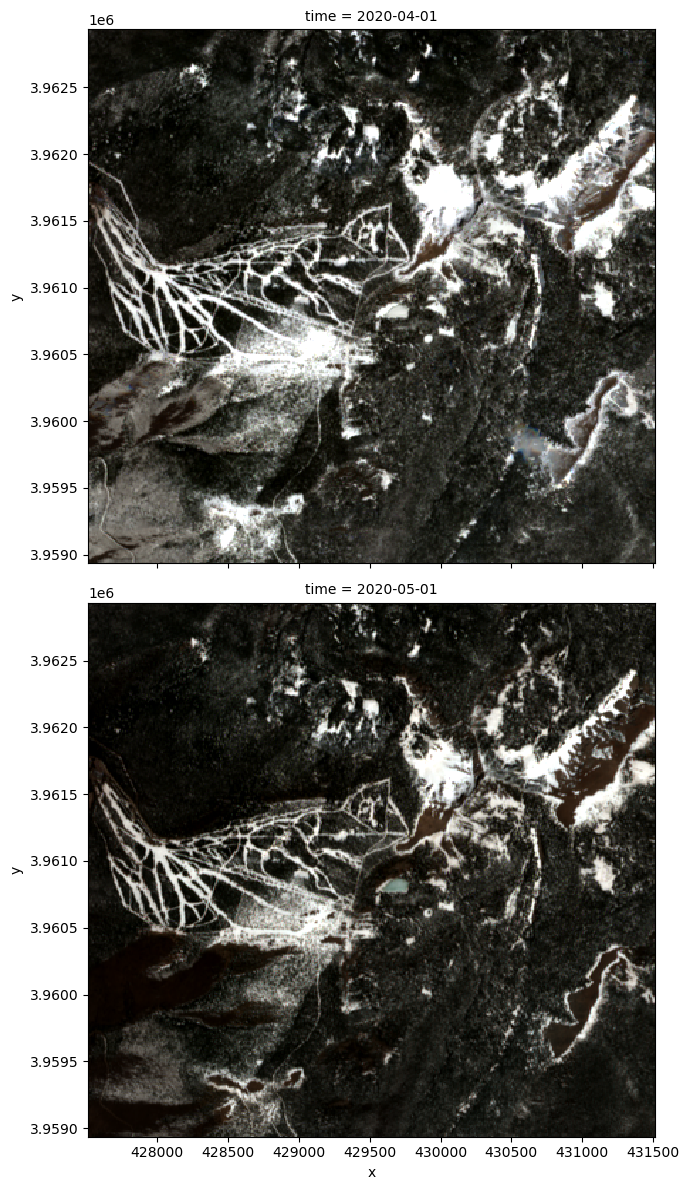

In [12]:
data.plot.imshow(row="time", rgb="band", robust=True, size=6);